<a href="https://colab.research.google.com/github/AmanullaChishty/Pytorch/blob/main/PyTorch_paper_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setup

In [1]:
import torch


In [2]:
!pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [3]:
import torchvision

In [4]:
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print("[INFO] Couldn't find going_modular or helper_functions...")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions...
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 26.10 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

In [6]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [8]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7eb4106c5b40>,
 ['pizza', 'steak', 'sushi'])

In [10]:
image_batch,label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

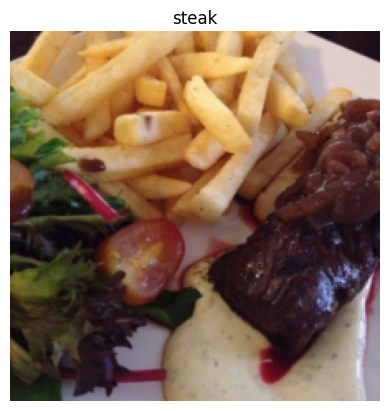

In [11]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper

In [12]:
## Calculating patch embedding input and output shapes by hand
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = (height * width) / (patch_size * patch_size)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")


Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196.0


In [13]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)
print(f"Embedding layer input shape: {embedding_layer_input_shape}")
print(f"Embedding layer output shape: {embedding_layer_output_shape}")

Embedding layer input shape: (224, 224, 3)
Embedding layer output shape: (196.0, 768)


(-0.5, 223.5, 223.5, -0.5)

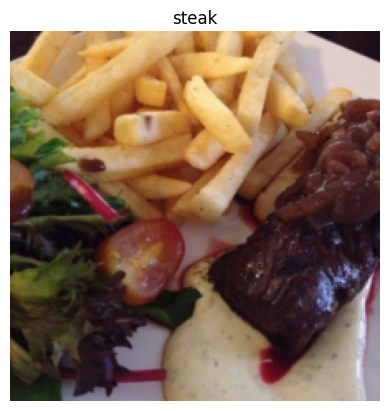

In [14]:
## Turning a single image into patches
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

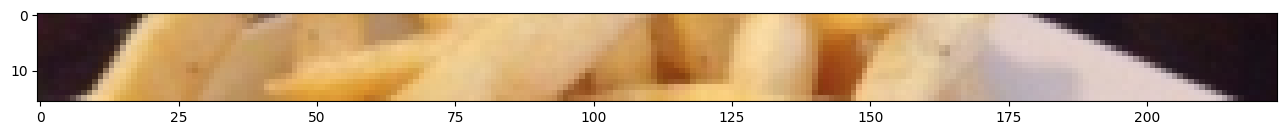

In [15]:
image_permuted = image.permute(1,2,0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


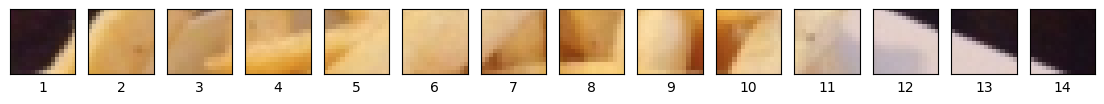

In [16]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size// patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


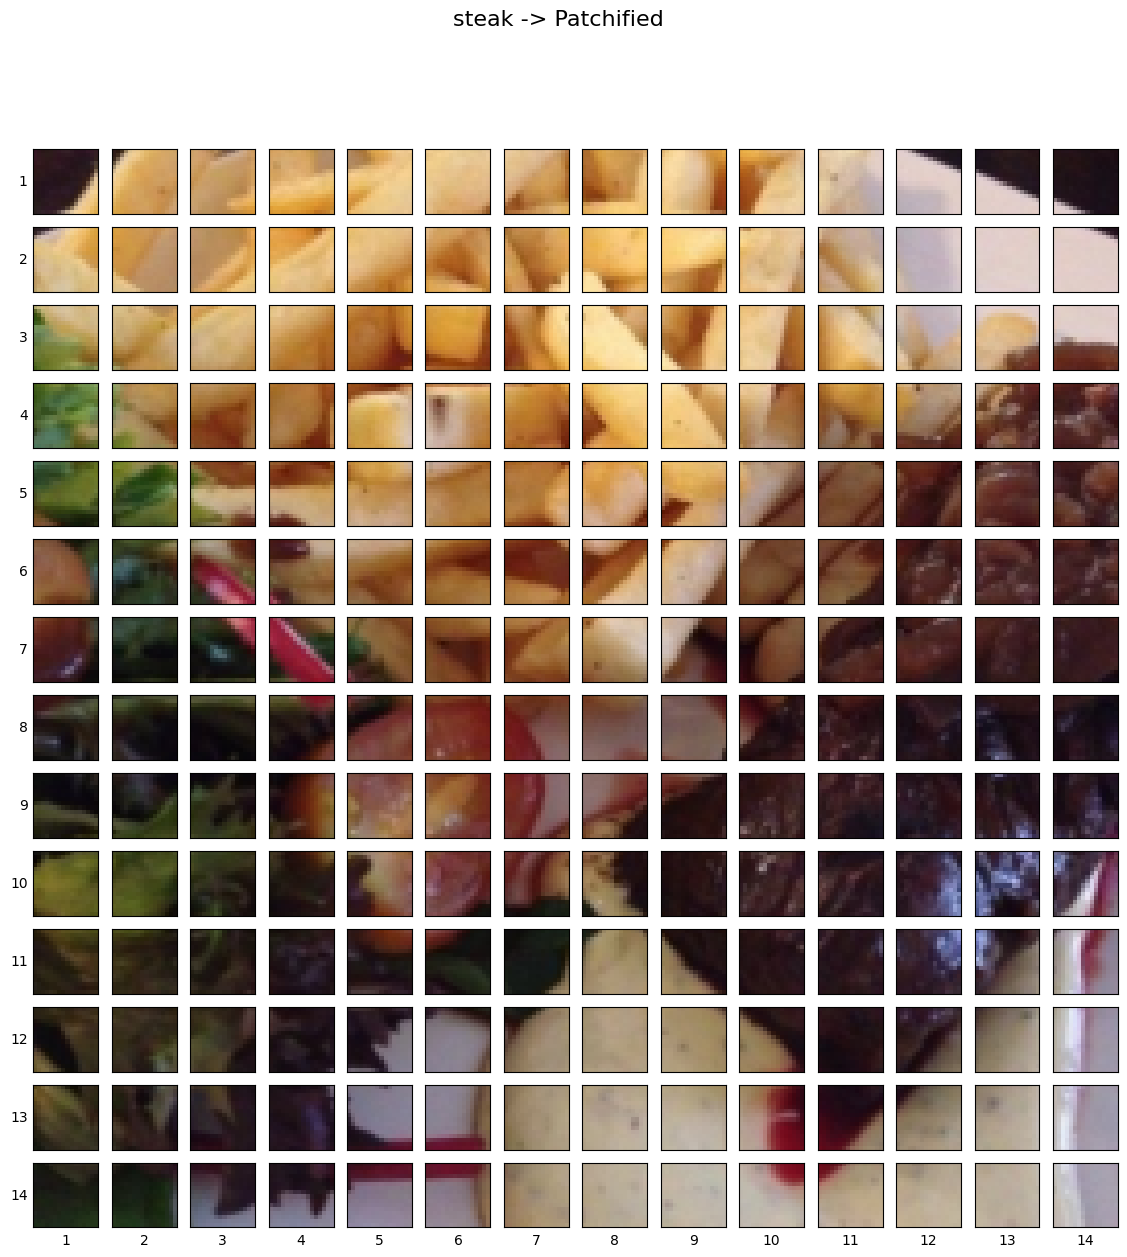

In [17]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size// patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0,img_size,patch_size)):
  for j, patch_width in enumerate(range(0,img_size,patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 16)
plt.show()


## 4. Image pataches with Conv2d

In [18]:


patch_size = 16
conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

(-0.5, 223.5, 223.5, -0.5)

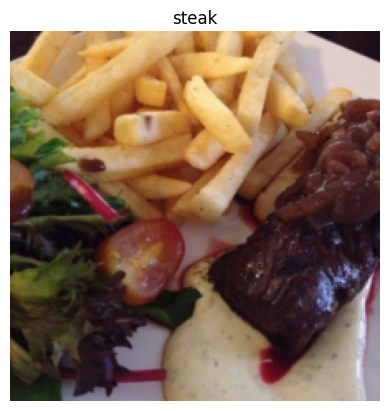

In [19]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [20]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape, '-> [batch_size, embedding_dim, feature_map_height, feature_map_width]')

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Showing random convolutional feature maps from indexes: [542, 447, 573, 300, 704]


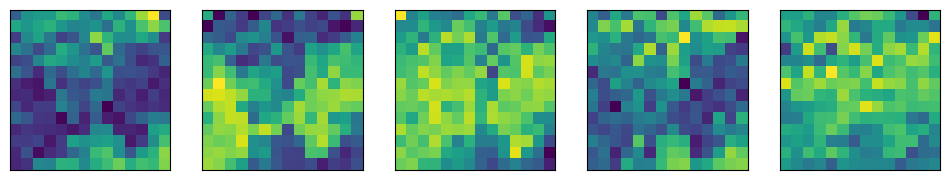

In [21]:
import random
random_indexes = random.sample(range(0,758), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(12,12))

for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [22]:
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[ 0.0898,  0.3892,  0.3514,  0.4188,  0.4516,  0.4342,  0.2733,
            0.3313,  0.3932,  0.2288,  0.4110,  0.4095,  0.1858,  0.1297],
          [ 0.4089,  0.3159,  0.3225,  0.3742,  0.3828,  0.2974,  0.2635,
            0.3969,  0.3776,  0.3951,  0.3116,  0.4356,  0.4511,  0.4034],
          [ 0.1844,  0.3311,  0.3759,  0.3016,  0.2845,  0.2234,  0.2875,
            0.4712,  0.3870,  0.3318,  0.3927,  0.4344,  0.4295,  0.4375],
          [ 0.1123,  0.2182,  0.1975,  0.2281,  0.4626,  0.3118,  0.3064,
            0.2710,  0.4526,  0.2811,  0.1444,  0.2652,  0.1227,  0.1223],
          [ 0.1488,  0.0562,  0.2329,  0.1904,  0.2368,  0.2492,  0.3247,
            0.3532,  0.2423,  0.2958,  0.1681,  0.1301,  0.1865,  0.1771],
          [ 0.2283,  0.1314,  0.0635,  0.1817,  0.1977,  0.1796,  0.1653,
            0.1299,  0.3656,  0.2060,  0.1933,  0.1213,  0.1307,  0.1181],
          [ 0.1278,  0.0558,  0.1974,  0.1891,  0.1607,  0.1354,  0.1825,
            0.3187,  0.2391,  0.

## 5. Flatteing the patch embedding with torch.nn.Flatten()

In [23]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [24]:
flatten = nn.Flatten(start_dim=2,end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image faure map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


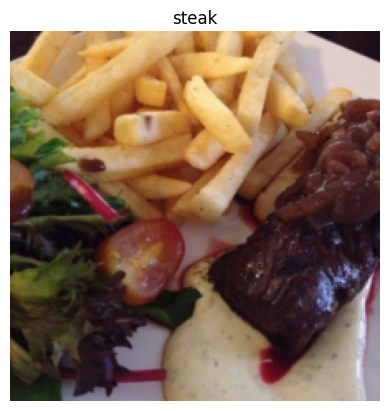

In [25]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f'Original image shape: {image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image faure map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [26]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

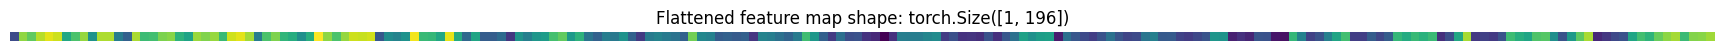

In [27]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [28]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0898,  0.3892,  0.3514,  0.4188,  0.4516,  0.4342,  0.2733,  0.3313,
           0.3932,  0.2288,  0.4110,  0.4095,  0.1858,  0.1297,  0.4089,  0.3159,
           0.3225,  0.3742,  0.3828,  0.2974,  0.2635,  0.3969,  0.3776,  0.3951,
           0.3116,  0.4356,  0.4511,  0.4034,  0.1844,  0.3311,  0.3759,  0.3016,
           0.2845,  0.2234,  0.2875,  0.4712,  0.3870,  0.3318,  0.3927,  0.4344,
           0.4295,  0.4375,  0.1123,  0.2182,  0.1975,  0.2281,  0.4626,  0.3118,
           0.3064,  0.2710,  0.4526,  0.2811,  0.1444,  0.2652,  0.1227,  0.1223,
           0.1488,  0.0562,  0.2329,  0.1904,  0.2368,  0.2492,  0.3247,  0.3532,
           0.2423,  0.2958,  0.1681,  0.1301,  0.1865,  0.1771,  0.2283,  0.1314,
           0.0635,  0.1817,  0.1977,  0.1796,  0.1653,  0.1299,  0.3656,  0.2060,
           0.1933,  0.1213,  0.1307,  0.1181,  0.1278,  0.0558,  0.1974,  0.1891,
           0.1607,  0.1354,  0.1825,  0.3187,  0.2391,  0.1289,  0.0627,  0.1570,
           0.095

## 6. Turning the ViT patch to PyTorch Module

In [29]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels=embedding_dim,kernel_size=patch_size,
                             stride = patch_size,
                             padding=0)

    self.flatten = nn.Flatten(start_dim=2,end_dim=3)

  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size ==0, f"Image resolution ({image_resolution}) must be divisible by the patch size ({patch_size})"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0,2,1)

In [31]:
set_seeds()
patchify = PatchEmbedding(in_channels=3,
                                 patch_size=16,
                                 embedding_dim=768)
print(f"Input image shape : {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape : torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [32]:
random_input_image = (1,3,224,224)
random_input_image_error = (1,3,250,250)

In [33]:
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17